In [1]:
# Imports
import json, re, numpy as np, numpy.linalg as nplin, matplotlib.pyplot as plt, matplotlib.mlab as mlab 
from __future__ import division
from operator import itemgetter
%matplotlib inline

In [ ]:
# Parse and load data
def parse(a):
    time = np.array(a['data'][0:4757])
    flux = np.array(a['data'][4757:])
    return (time, flux)

lc = sc.textFile("s3n://stat-37601/lightcurves.json")\
    .map(json.loads)\
    .filter(lambda js: len(js['data'])==4757*2)\
    .map(parse)\
    .cache()

### PART I. DETECTING TRANSITS AND ECLIPSING BINARY STARS

In [ ]:
# Count observations
print lc.count()

#### (a) Fit the light curve using Nadaraya-Watson kernel estimator

In [117]:
# I'm using the Epanechnikov kernel because it's smooth and has compact support
# Could also use the Tricube, though it tends not to make much difference

def epanechinkov(u):
    '''Evaluates the epanechinkov kernel for each value of a numpy array'''
    # It seems like subsetting the data first should be quickest
    return (1 - u*u) * (abs(u) <=1)

def kernel_regression(y,h,kernel=epanechinkov,gap=.0204):
    '''Performs kernel regression on y with bandwidth h and returns the fit values and estimated loo cv error'''
    N = len(y)
    size = min((N-1)/2,h//gap)
    not_missing = np.logical_not(np.isnan(y))
    # As long as we use a kernel with compact support, the weight vector doesn't need to be as long as the data 
    u = np.arange(-size,size+1,1,dtype=np.float64)*gap/h
    w = kernel(u)
    # We want missing values not included in the regression
    const = np.convolve(w,not_missing,'same')
    const[const==0] = 1    # to avoid division by 0
    yhat  = np.convolve(w,np.nan_to_num(y),'same')/const
    # Calculate leave one out cross validation
    leverage = kernel(0)/const[not_missing]
    cv_error = np.sum(((y-yhat)[not_missing]/(1-leverage))**2)/N
    return yhat, cv_error

def best_kernel_regression(y,bandwidths,kernel=epanechinkov,gap=.0204):
    '''Fits a kernel_regression for each bandwidth and returns one with lowest LOOCV'''
    cv_error  = float("inf")
    yhat      = None
    bandwidth = None
    # Loop through the potential bandwidths and see which fits best
    for h in bandwidths:
        yhat_cur, cv_error_cur = kernel_regression(y,h,kernel,gap)
        if cv_error_cur<cv_error:
            cv_error, yhat, bandwidth = cv_error_cur, yhat_cur, h
    return yhat, bandwidth

In [143]:
test_cases = lc.take(5)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


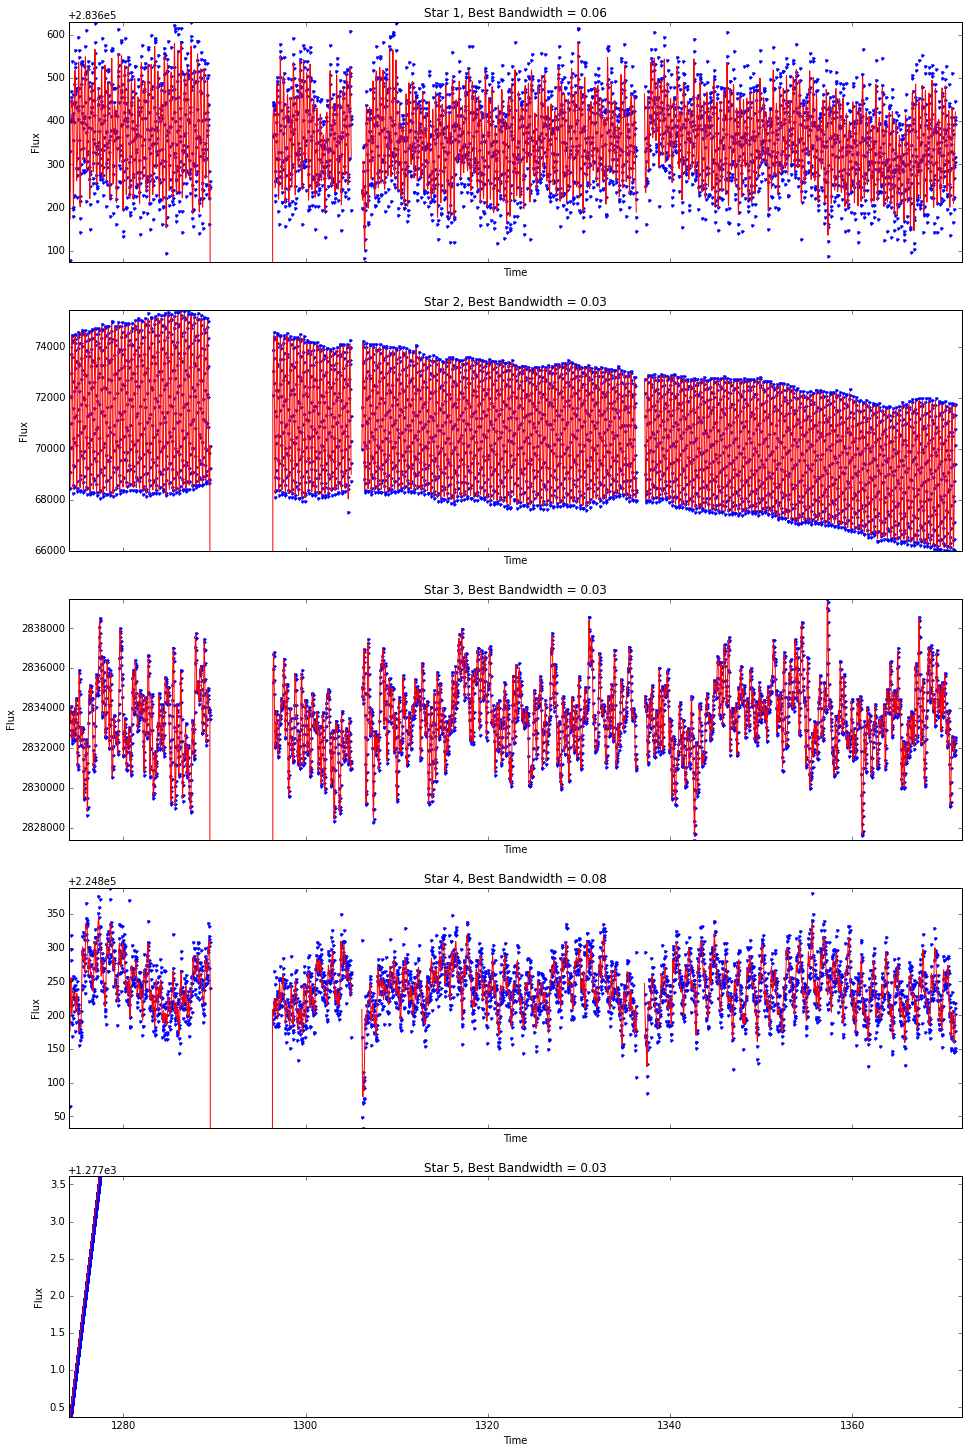

In [145]:
# Lets see how the regressions look on the first few stars
f,subplts = plt.subplots(len(test_cases),1, sharex='col')
f.set_size_inches(16,25)
for i, (x,y) in enumerate(test_cases):
    yhat, h = best_kernel_regression(y,[.01,.03,.06,.08,.1,.2,.5,.7,1,1.3,1.6,2])
    subplts[i].set_title('Star %d, Best Bandwidth = %.2f' % (i+1,h))
    subplts[i].set_xlabel('Time')
    subplts[i].set_ylabel('Flux')
    subplts[i].set_xlim(1274, 1372)
    subplts[i].set_ylim(np.nanmin(y,axis=0),np.nanmax(y,axis=0))
    subplts[i].plot(x,y,'b.',x,yhat,'r-')

plt.show()

In [141]:
print len(x),len(y),len(yhat)

4757 4757 4757
